In [28]:
%matplotlib inline


# Poisson regression


We would like to use an example to show how the sparse-constrained optimization for poisson regression works in our program.

## Introduction to poisson regression
Poisson Regression involves regression models in which the response variable is in the form of counts.
For example, the count of number of car accidents or number of customers in line at a reception desk.
The response variables is assumed to follow a Poisson distribution.

The general mathematical equation for Poisson regression is

<a id='generation'></a>
$$
\begin{align}\log(E(y)) = \beta_0 + \beta_1 X_1+\beta_2 X_2+\dots+\beta_p X_p.\end{align} \tag{1}
$$

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{y_i x_i^T \beta-\exp \left(x_i^T \beta\right)-\log  \left(y!\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s .\tag{2}
$$

Here is Python code for solving sparse poisson regression problem:

### Import necessary packages

In [29]:
import numpy as np
from abess.datasets import make_glm_data
import jax.numpy as jnp
from skscope import ScopeSolver

### Set a seed

In [30]:
np.random.seed(1234)

### Generate the data

Firstly, we generate some artificial data using logic [1](#generation). Consider a dataset containing n=500 observations with p=500 variables. The `make_glm_data` function allows us to generate simulated data by specifying the `family="poisson"`. By specifying k = 5, we set only 5 of the 500 variables to have effect on the expectation of the response.

In [39]:
n = 500
p = 500
s = 5

data = make_glm_data(n=n, p=p, k=s, family="poisson")
X = data.x
y = data.y

### Define function to calculate negative log-likelihood of poisson regression to serve as the loss to solve

Secondly, we define the loss function `poisson_loss` accorting to [2](#loss) that matches the data generating function `make_glm_data`.

In [32]:
def poisson_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.sum(jnp.exp(xbeta) - y * xbeta) #omit \log y! term

### Use skscope to solve the sparse possion regression problem

After defining the data generation and loss function, we can call `ScopeSolver` to solve the sparse-constrained optimization problem. We will use SIC to decide the optimal support size.

In [33]:
from skscope.utilities import SIC

solver = ScopeSolver(p, sparsity = range(1,10), sample_size = n, ic_method = SIC)
params = solver.solve(poisson_loss, jit=True)

Now the `solver.params` contains the coefficients of poisson model with no more than 5 variables. That is, those variables with a coefficient 0 is unused in the model.

We can further compare the coefficients estimated by `skscope` and the real coefficients in three-fold:

* The true support set and the estimated support set

* The true nonzero parameters and the estimated nonzero parameters

* The true loss value and the estimated values

In [35]:
true_support_set = np.nonzero(data.coef_)[0]
estimated_support_set = solver.support_set
print("True support set: ", true_support_set)
print("Estimated support set: ", estimated_support_set)

True support set:  [ 53 331 336 393 431]
Estimated support set:  [ 53 331 336 393 431]


In [36]:
print("True parameters: ", data.coef_[true_support_set])
print("Estimated parameters: ", solver.params[estimated_support_set])

True parameters:  [-4.59545963  7.8660496   7.09934975 -6.71406003 -5.76856858]
Estimated parameters:  [-4.59741833  7.96903051  7.83567449 -6.3614927  -5.50868553]


In [37]:
print("True loss value: ", poisson_loss(data.coef_))
print("Estimated loss value: ", poisson_loss(solver.params))

True loss value:  121.09512
Estimated loss value:  119.89359


## More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

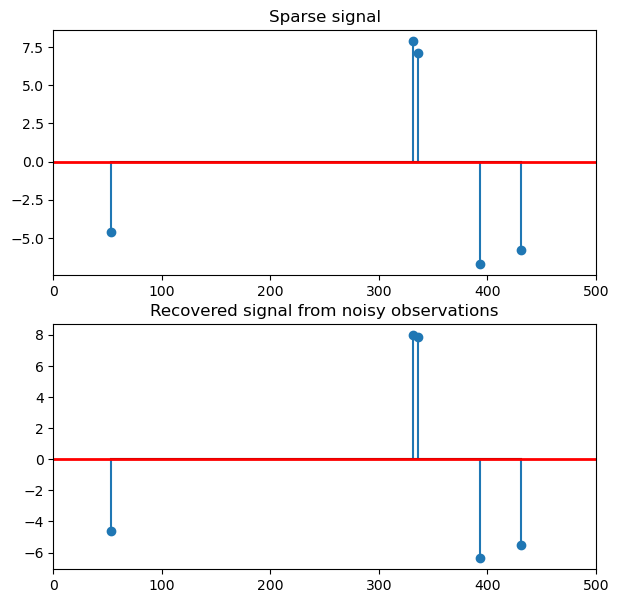

In [38]:
import matplotlib.pyplot as plt
(inx_true,) =  data.coef_.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(inx_true, data.coef_[inx_true], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(inx_est, solver.params[inx_est], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()